In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
data = pd.read_csv('../data/other/color_relations.csv')

In [9]:
eta = lambda bv0: 0.97 - 0.09 * bv0

e_bv = lambda bv0,e_bv0: eta(bv0)/eta(0) * e_bv0 

e_ub = lambda e_bv,alpha,beta,gamma: alpha * e_bv + beta * e_bv**2 + gamma * e_bv**3

def redden_f70(e_bv0):
    bv0_arr = data['(B-V)0'].values
    ub0_arr = data['(U-B)0'].values
    alpha_arr = data['alpha'].values
    beta_arr = data['beta'].values
    gamma_arr = data['gamma'].values
    
    e_bv_arr = e_bv(bv0_arr,e_bv0)
    e_ub_arr = e_ub(e_bv_arr,alpha_arr,beta_arr,gamma_arr)

    bv0_arr_reddened = bv0_arr + e_bv_arr
    ub0_arr_reddened = ub0_arr + e_ub_arr
    
    return bv0_arr_reddened,ub0_arr_reddened

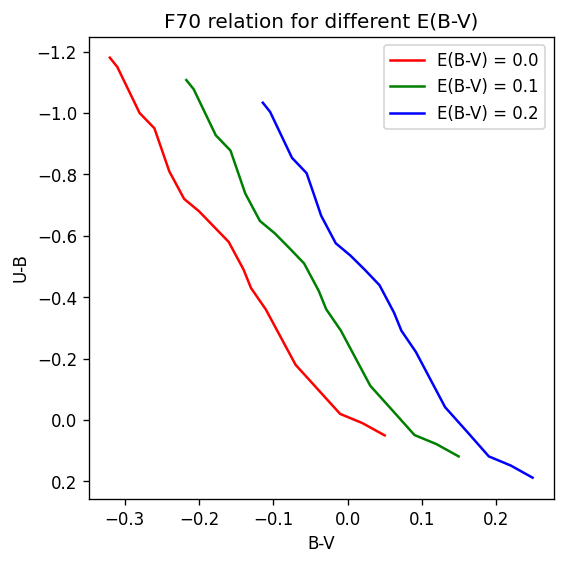

In [12]:
x1,y1 = redden_f70(0.0)
x2,y2 = redden_f70(0.1)
x3,y3 = redden_f70(0.2)

fig,ax = plt.subplots(figsize=(5,5),dpi = 120)
ax.set_xlabel('B-V')
ax.set_ylabel('U-B')
ax.set_title('F70 relation for different E(B-V)')
ax.plot(x1,y1,'r',label='E(B-V) = 0.0')
ax.plot(x2,y2,'g',label='E(B-V) = 0.1')
ax.plot(x3,y3,'b',label='E(B-V) = 0.2')
ax.legend()

ax.invert_yaxis()
plt.show()